In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Week 2 : Systematically Improving Your Rag Application

# Why Fine-tune Embeddings?

> If you have not already, please make sure that you've gone through Week 1's notebooks. That'll help to contextualise this week's notebook.

A common misconception is that fine-tuning is difficult and requires a large amount of data. From our own experiments, that's not the case. 

With just 100 examples, we were able to beat proprietary models like OpenAI's `text-embedding-3-small` and achieve greater accuracy at a lower price point with open source embedding models such as `bge-base-en-v1.5` ( See [Fine Tuning Embeddings With Modal](https://modal.com/blog/fine-tuning-embeddings)) on the Quora dataset. For most applications, that's less than **1-2 weeks worth of data**. 

## Replicating Ramp's Process

> Read the blog post here at https://engineering.ramp.com/transaction-embeddings

Ramp fine-tuned an embedding model on transaction data to automatically suggest expense categories. Even though each customer's expense categories were unique, their model accurately generalized to new customers. This showcases how fine-tuning can adapt models to specific, real-world tasks.

We're going to replicate Ramp's process using synthetic financial transaction data that we'll generate from scratch. This will give a step by step guide to fine-tune an embedding model for your own applications, whether it's through a proprietary model provider like Cohere or an open source embedding model. 

We have defined 25 categories ahead of time that we'll use to classify our synthetic transactions. Each transaction should map to a single category. We want to measure the ability of a model to identify the correct category for each transaction using just embeddings.

This will be done in 3 main steps

1. **Understand Transaction Dataset** : We'll learn about the type of data used by Ramp to fine-tune their embedding model and how we can replicate that with synthetic data using `instructor`.

2. **Iterate on Synthetic Data** : We'll then iteratively generate a large dataset of transactions by generating examples with a language model and then selecting the best examples manually using a streamlit dataset. For each new batch of transactions, we'll verify that these are challenging examples by evaluating the recall performance of a baseline with our initial questions.

3. **Evaluate and Fine-Tune Models** : Once we've generated enough questions, we'll then split our data into a train and evaluation set that we can use to evaluate the performance improvements of fine-tuning an embedding model. We'll do so with both Cohere's reranker models and an open source embedding model.

Throughout this process, we'll use [braintrust](https://braintrust.dev) to collect data and measure improvements. Braintrust makes it easy to collaborate with a team and simplifies data collection and evaluation.



## Understanding Transactions

To fine-tune our model effectively, we need to understand the transaction data we're working with.

Typical Transaction Fields:

- Merchant Name: The vendor or service provider's name.
- Merchant Category Code (MCC): General category of the transaction (e.g., Restaurants).
- Department Name: The company department responsible for the transaction.
- Location: Where the transaction took place.
- Amount: The transaction's monetary value.
- Spend Program Name: Specific budget or spend limit allocated.
- Trip Name: If the transaction occurred during travel.

We can see an example below

```
Name : Beirut Bakery
Category: Restaurants, Cafeteria
Department: Engineering
Location: Calgary, AB, Canada
Amount: 56.67 CAD
Card: Ramp's Physical Card
Trip Name: unknown
```

This is a difficult task because there's very little information. Additionally since each company has unique categories that have some implicit rules, it's difficult for a general embedding model to classify these transactions without fine-tuning.

# Generating Synthetic Transactions

We'll generate a synthetic transaction dataset in 3 steps

1. **Initial Examples** : We'll create a batch of basic transactions using `gpt-4o-min` and manually review them to create a small dataset of good and bad examples.

2. **Refine Data** : We'll then randomly select a subset of these initial examples and use them to generate new examples that are more challenging by adding them to the prompt as few shot examples.

3. **Braintrust Evaluation** : We'll then use `braintrust` to evaluate the recall@1,3,5 and mrr@1,3,5 of our initial and refined examples. 

We recommend using `ChatGPT` to evaluate these examples and get a sense for what makes a good or bad example during this process. We'll iterate on this until we've generated at least 300 examples. This will ensure that we have enough examples to fine-tune a cohere re-ranker ( requires min 256 examples) or a sentence transformer model while also having enough examples to create a held out evaluation set. 

There are two key advantages to iteratively generating our dataset in small batches

1. **Practicality** : A small amount of data is easy to label
2. **Randomness** : By constantly sampling from our growing number of examples, we're able to have enough randomness to create a diverse dataset. This helps us to avoid potential issues with diversity and quality that doing a single pass of data generation can introduce.


## Step 1 : Generating our initial transactions.

We'll start by generating our initial transactions using a simple prompt. These are going to be very simple examples that will not be great but they are useful as an initial starting point.


In [11]:
from pydantic import BaseModel, field_validator, ValidationInfo
from openai import AsyncOpenAI
import instructor
from typing import Optional
from textwrap import dedent
import random
import json
import asyncio

# Load in pre-defined categories
categories = json.load(open("data/categories.json"))


# Define a Pydantic model that can represent the same transaction data that Ramp was using
class Transaction(BaseModel):
    merchant_name: str
    merchant_category: list[str]
    department: str
    location: str
    amount: float
    spend_program_name: str
    trip_name: Optional[str] = None
    expense_category: str

    def format_transaction(self):
        return dedent(f"""
        Name : {self.merchant_name}
        Category: {", ".join(self.merchant_category)}
        Department: {self.department}
        Location: {self.location}
        Amount: {self.amount}
        Card: {self.spend_program_name}
        Trip Name: {self.trip_name if self.trip_name else "unknown"}
        """)

    @field_validator("expense_category")
    @classmethod
    def validate_expense_category(cls, v, info: ValidationInfo):
        # We use this later to read in the generated transactions
        if not info.context:
            return v

        # Validate that we've generated the right expense category
        assert (
            v == info.context["category"]["category"]
        ), f"The transaction must have an expense category of {info.context['category']['category']} instead of {v}"
        return v


client = instructor.from_openai(AsyncOpenAI())


async def generate_transaction(category):
    return await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": """Generate a transaction for a tech company that could be filed under the category of {{ category }}. This should be distinct from the sample_transactions provided in the categories.json file

                - The spend program is a specific spending authority or allocation that has defined limits, rules, and permissions. It's like a virtual card or spending account set up for a specific purpose.
                - Merchant Category Name is a label that best describes the merchant of the transaction.
                - Merchant name should be realistic and not obviously made up.
                """,
            }
        ],
        context={"category": category},
        response_model=Transaction,
    )

In [12]:
# Generate 5 initial transactions and choose the category randomly
coros = []
for _ in range(5):
    coros.append(generate_transaction(random.choice(categories)))

transactions = await asyncio.gather(*coros)
with open("./data/generated_transactions.jsonl", "a") as f:
    for transaction in transactions:
        f.write(transaction.model_dump_json() + "\n")

## Step 2 : Labeling Transactions

Now that we've generated a small set of initial transactions, please run `streamlit run label.py` to manually select transactions that you think might be difficult to classify. 

> You can modify and edit the transaction details before approving them. Hot keys of ctrl + e ( approve ) and ctrl + r ( reject ) make this process much faster. Only approved transactions will be saved to `generated_transactions.jsonl` below. We'll then use these examples to generate a new set of transactions that are more challenging.

You can also manually override transaction details in the streamlit application. We recommend using `ChatGPT` or `Claude` to discuss and generate good default and examples. A prompt that I used to prompt the chat UI was

```
I'd like to generate a transaction for a tech company that is challenging to classify into a specific category. Here are the details

<Details go here>

I'd like you to help rewrite some of the details to make it more realistic. Please stick to the following rules

- MCCs should be realistic. If possible, let's try to use a MCC that will cover a superset of the given category
- Let's try to suggest a non-uniform number (Eg. not 1500 ) so that it seems more realistic
- The Spend Program name should be a specific spending authority or allocation that has defined limits, rules, and permissions. It's like a virtual card or spending account set up for a specific purpose. In our case, this spend program name should not be a name that directly mentions the category or merchant
```



In [234]:
async def generate_transaction_with_examples(category, examples: list[Transaction]):
    return await client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": """
                Generate a potentially ambiguous business transaction that could reasonably be categorized as {{ category }} or another similar category. The goal is to create transactions that challenge automatic categorization systems by having characteristics that could fit multiple categories.


                Available categories in the system.:
                <categories>
                {% for category_option in categories %}
                    {{ category_option["category"] }}
                {% endfor %}
                </categories>

                
                The transaction should:
                1. Use a realistic but non-obvious merchant name (international names welcome), don't use names that are obviously made u 
                2. Include a plausible but non-rounded amount with decimals (e.g., $1247.83)
                3. Be difficult to categorize definitively (could fit in multiple categories)
                4. Merchant Category Name(s) should not reference the category at all and should be able to be used for other similar categories if possible.

                Here are some good examples of transactions that were previously generated for other categories.

                {% for example in examples %}
                {{ example.model_dump_json() }}
                {% endfor %}
                """,
            }
        ],
        context={"category": category, "examples": examples, "categories": categories},
        response_model=Transaction,
    )

In [240]:
with open("./data/cleaned.jsonl", "r") as f:
    sample_transactions = []
    for line in f:
        sample_transactions.append(Transaction(**json.loads(line)))


coros = []
for _ in range(20):
    coros.append(
        generate_transaction_with_examples(
            random.choice(categories), random.sample(sample_transactions, 10)
        )
    )

transactions = await asyncio.gather(*coros)

with open("./data/generated_transactions.jsonl", "w") as f:
    for transaction in transactions:
        f.write(transaction.model_dump_json() + "\n")

## Step 3 : Evaluating Recall and MRR Performance.

Remember that we're building a model that can suggest transaction categories to a user. To do so, we'll only be able to show the top 3-5 results and we want to make sure that the correct result is ranked as highly as possible.

Therefore, we'll be using recall and mrr to evaluate our mode's performance here. 

- `recall` : This measures whether the correct category is in the top k retrieved results.
- `mrr` : This measures how highly is the correct category ranked in the retrieved results.

Ideally we want a model with a high recall and mrr. This means that when we display the results, they're likely to be relevant to the user. By measuring the recall and mrr, we're able to ensure that we're conssitently generating questions that the model finds challenging. 

We're using `lancedb` here since it provides an easy way to perform these evaluations with automatic batching of embeddings for queries and data along with a single api for vector search and reranking.

In [3]:
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry

func = get_registry().get("openai").create(name="text-embedding-3-small")
categories = json.load(open("data/categories.json"))


class Category(LanceModel):
    text: str = func.SourceField()
    embedding: Vector(func.ndims()) = func.VectorField()


db = lancedb.connect("./lancedb")
table = db.create_table("categories", schema=Category, mode="overwrite")


table.add(
    [
        {
            "text": category["category"],
        }
        for category in categories
    ]
)

table.create_fts_index(field_names=["text"], replace=True)

[2024-11-13T13:01:46Z WARN  lance::dataset] No existing dataset at /Users/ivanleo/Documents/coding/systematically-improving-rag/cohort_2/week2/lancedb/categories.lance, it will be created


In [14]:
from braintrust import Eval, Score
from helpers import get_metrics_at_k, task

transactions = []
for line in open("./data/cleaned.jsonl").readlines():
    transactions.append(Transaction(**json.loads(line)))


def evaluate_braintrust(input, output, **kwargs):
    metrics = get_metrics_at_k(metrics=["mrr", "recall"], sizes=[1, 3, 5])
    return [
        Score(
            name=metric,
            score=score_fn(output, kwargs["expected"]),
            metadata={"query": input, "result": output, **kwargs["metadata"]},
        )
        for metric, score_fn in metrics.items()
    ]


await Eval(
    "fine-tuning",  # Replace with your project name
    data=lambda: [
        {
            "input": transaction.format_transaction(),
            "expected": [transaction.expense_category],
        }
        for transaction in transactions
    ],  # Replace with your eval dataset
    task=lambda query: task(
        user_query=query, table=table, reranker=None, max_k=25
    ),  # Replace with your LLM call
    scores=[evaluate_braintrust],
)

Experiment fine-tuning-1731505293 is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731505293
fine-tuning (data): 326it [00:00, 50494.59it/s]


fine-tuning (tasks):   0%|          | 0/326 [00:00<?, ?it/s]


=========================SUMMARY=========================
fine-tuning-1731505293 compared to fine-tuning-1731505282:
38.65% 'mrr@1'    score
49.44% 'mrr@3'    score
52.29% 'mrr@5'    score
38.65% 'recall@1' score
63.80% 'recall@3' score
76.38% 'recall@5' score

11.18s duration

See results for fine-tuning-1731505293 at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731505293


EvalResultWithSummary(summary="...", results=[...])

At this point, we've generated a large dataset of synthetic transactions that we can use to fine-tune a model on. However, it's important here to call out that synthetic data has its challenges.

1. Quality and Diversity : It's difficult to ensure that the synethic data is of high quality and diverse. We've done so by manually reviewing and selecting good examples but ultimately we need real production data to ensure that our model is able to generalise.

2. Human Error : Manual review is great to ensure the quality of transactions but is expensive and error prone. This is not something that scales well, especially if you're trying to generate thousands of examples which you'd like humans to manually label.

We want to treat this synthetic data as a starting point and iteratively make it better using the techniques we've discussed in this notebook. But you will need to eventually mix in production data and continue generating synthetic data in order to adequately evaluate and test the generalisation capabilities of your model.



# Creating a Dataset

We want to segregate our data into a train and evaluation set because it allows us to evaluate the performance of our model on data that it hasn't seen before. We use `braintrust` here to upload our dataset and a simple metadata flag to segregate between a train and evaluation portion of our dataset. This allows us to easily run evaluations on our model in the subsequent notebooks later on.

If we fine-tuned our model on the same data that we evaluated it on, it would be difficult to tell if the improvements we made were due to the model generalizing better or due to overfitting. In this case, we're just going to split our data by randomly shuffling it and then selecting the first 80% as our training set and the remaining 20% as our evaluation set.

In practice, you'd want to think carefully about these splits - using the category as a way to ensure that we have a diverse set of examples or generating new labels for the evaluation set based on the training labels. (Eg. Restaurants -> Dining Establishments or randomly grouping categories together )

Before we start fine-tuning our models here, we also need to make sure that the evaluation set and training set are similar. We do so by measuring the recall and mrr and verifying that they have similar values.

In [245]:
from braintrust import init_dataset

train_ratio = 0.8 * len(transactions)

random.shuffle(transactions)

train_transactions = transactions[: int(train_ratio)]
eval_transactions = transactions[int(train_ratio) :]

dataset = init_dataset(project="fine-tuning", name="Synthetic Transactions")

for transaction in train_transactions:
    dataset.insert(
        input=transaction.generate_transaction(),
        expected=[transaction.expense_category],
        metadata={"split": "train"},
    )

for transaction in eval_transactions:
    dataset.insert(
        input=transaction.generate_transaction(),
        expected=[transaction.expense_category],
        metadata={"split": "eval"},
    )

print(dataset.summarize())

DatasetSummary(
    project_name='fine-tuning',
    dataset_name='Synthetic Transactions',
    project_url='https://www.braintrust.dev/app/567/p/fine-tuning',
    dataset_url='https://www.braintrust.dev/app/567/p/fine-tuning/datasets/Synthetic%20Transactions',
    data_summary=DataSummary(new_records=326, total_records=326)
)

Now let's see if we can get a baseline performance for each individual split

In [17]:
from braintrust import init_dataset


def get_dataset_split(split: str, dataset):
    return [
        {
            "input": transaction["input"],
            "expected": transaction["expected"],
        }
        for transaction in dataset
        if transaction["metadata"]["split"] == split
    ]


dataset = init_dataset(project="fine-tuning", name="Synthetic Transactions")
train_data = get_dataset_split("train", dataset)
eval_data = get_dataset_split("eval", dataset)
len(train_data), len(eval_data)


(260, 66)

In [21]:
from lancedb import connect

datasets = [["train", train_data], ["eval", eval_data]]

db = connect("./lancedb")
table = db.open_table("categories")


results = []
for dataset_name, dataset_partition in datasets:
    results.append(
        await Eval(
            "fine-tuning",
            experiment_name=f"synthetic-transactions-{dataset_name}",
            data=lambda: dataset_partition,
            task=lambda query: task(
                user_query=query, table=table, reranker=None, max_k=25
            ),  # Replace with your LLM call
            scores=[evaluate_braintrust],
        )
    )

Experiment synthetic-transactions-train-8dddfd6c is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/synthetic-transactions-train-8dddfd6c
fine-tuning [experiment_name=synthetic-transactions-train] (data): 260it [00:00, 68551.61it/s]


fine-tuning [experiment_name=synthetic-transactions-train] (tasks):   0%|          | 0/260 [00:00<?, ?it/s]


=========================SUMMARY=========================
synthetic-transactions-train-8dddfd6c compared to synthetic-transactions-eval:
38.08% 'mrr@1'    score
49.36% 'mrr@3'    score
52.24% 'mrr@5'    score
38.08% 'recall@1' score
64.23% 'recall@3' score
76.92% 'recall@5' score

8.51s duration

See results for synthetic-transactions-train-8dddfd6c at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/synthetic-transactions-train-8dddfd6c


Experiment synthetic-transactions-eval-37b9e6f9 is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/synthetic-transactions-eval-37b9e6f9
fine-tuning [experiment_name=synthetic-transactions-eval] (data): 66it [00:00, 14692.64it/s]


fine-tuning [experiment_name=synthetic-transactions-eval] (tasks):   0%|          | 0/66 [00:00<?, ?it/s]


=========================SUMMARY=========================
synthetic-transactions-eval-37b9e6f9 compared to synthetic-transactions-train-8dddfd6c:
40.91% 'mrr@1'    score
49.75% 'mrr@3'    score
52.47% 'mrr@5'    score
40.91% 'recall@1' score
62.12% 'recall@3' score
74.24% 'recall@5' score

2.81s duration

See results for synthetic-transactions-eval-37b9e6f9 at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/synthetic-transactions-eval-37b9e6f9


# Results and Analysis

In [23]:
import pandas as pd
scores = []

for result in results:
    result_scores = {}
    for score_name, score in result.summary.scores.items():
        result_scores[score_name] = score.score
    scores.append(result_scores)

df = pd.DataFrame(scores,index=["Train", "Eval"])
df.round(2)

,mrr@1,mrr@3,mrr@5,recall@1,recall@3,recall@5
Train,0.38,0.49,0.52,0.38,0.64,0.77
Eval,0.41,0.50,0.52,0.41,0.62,0.74


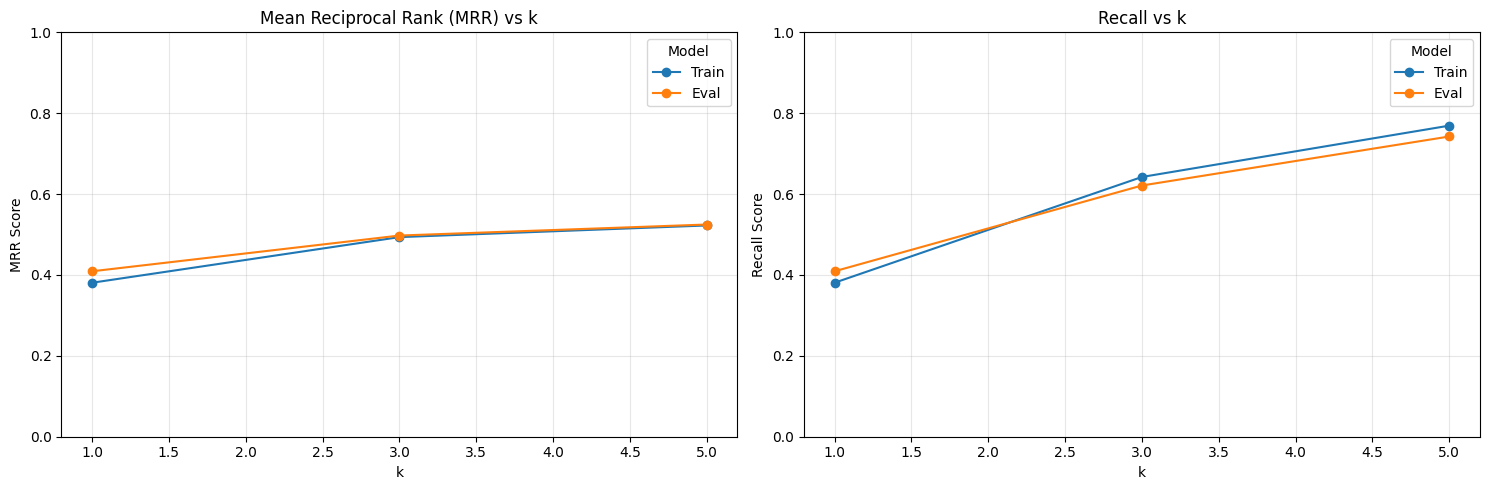

In [25]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Extract k values from column names and convert to numeric
k_values = [int(col.split('@')[1]) for col in df.columns if col.startswith('mrr')]

# Plot MRR values as lines
mrr_cols = [f'mrr@{k}' for k in k_values]
for model in df.index:
    ax1.plot(k_values, df.loc[model, mrr_cols], marker='o', label=model)
ax1.set_title('Mean Reciprocal Rank (MRR) vs k')
ax1.set_xlabel('k')
ax1.set_ylabel('MRR Score')
ax1.legend(title='Model')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Plot Recall values as lines
recall_cols = [f'recall@{k}' for k in k_values]
for model in df.index:
    ax2.plot(k_values, df.loc[model, recall_cols], marker='o', label=model)
ax2.set_title('Recall vs k')
ax2.set_xlabel('k')
ax2.set_ylabel('Recall Score')
ax2.legend(title='Model')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()


We can see here that the train and eval set have similar values for mrr and recall. This suggests that both sets are drawn from the same underlying distribution and that we're able to get a good estimate of how our model will perform on unseen data.

While these results are promising for our proof-of-concept, it's important to note that a production implementation would benefit from more sophisticated validation strategies. 

This could include

1. Generating synonymous labels to test if the model is able to generalise to other similar labels
2. Implementing multiple validation sets with different characteristics
3. Carefully managing data composition to prevent leakage

These enhancements are out of the scope of this notebook and we'll leave that for a production implementation. In the meantime, let's move on to using cohere's re-ranker models to fine-tune our embedding model.

